In [75]:
import pandas as pd 
import numpy as np 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC

In [76]:
df = pd.read_csv('../league_dataset_60k.csv')
grouped = df.groupby(df.teamPosition)
data_top = grouped.get_group("TOP")

## A Peek inside the Datasets

In [77]:
data_top.head(5)

,teamPosition,12AssistStreakCount,abilityUses,acesBefore15Minutes,alliedJungleMonsterKills,baronTakedowns,blastConeOppositeOpponentCount,bountyGold,buffsStolen,completeSupportQuestInTime,...,trueDamageTaken,turretKills,turretsLost,unrealKills,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
0,TOP,0,226,0,16.0,0,0,0,0,0,...,5811,2,7,0,0,9,1,0,6,0
5,TOP,0,189,0,8.0,0,0,0,1,0,...,5275,2,6,0,0,18,0,0,11,1
10,TOP,0,248,0,0.0,0,0,0,0,0,...,3643,2,9,0,0,19,1,0,6,0
15,TOP,0,151,0,0.0,1,0,0,0,0,...,150,5,3,0,0,17,0,1,9,1
20,TOP,0,334,0,4.5,0,0,150,0,0,...,2826,2,11,0,0,25,2,1,11,0


# Feature selection

## Feature importance logistic regression

C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


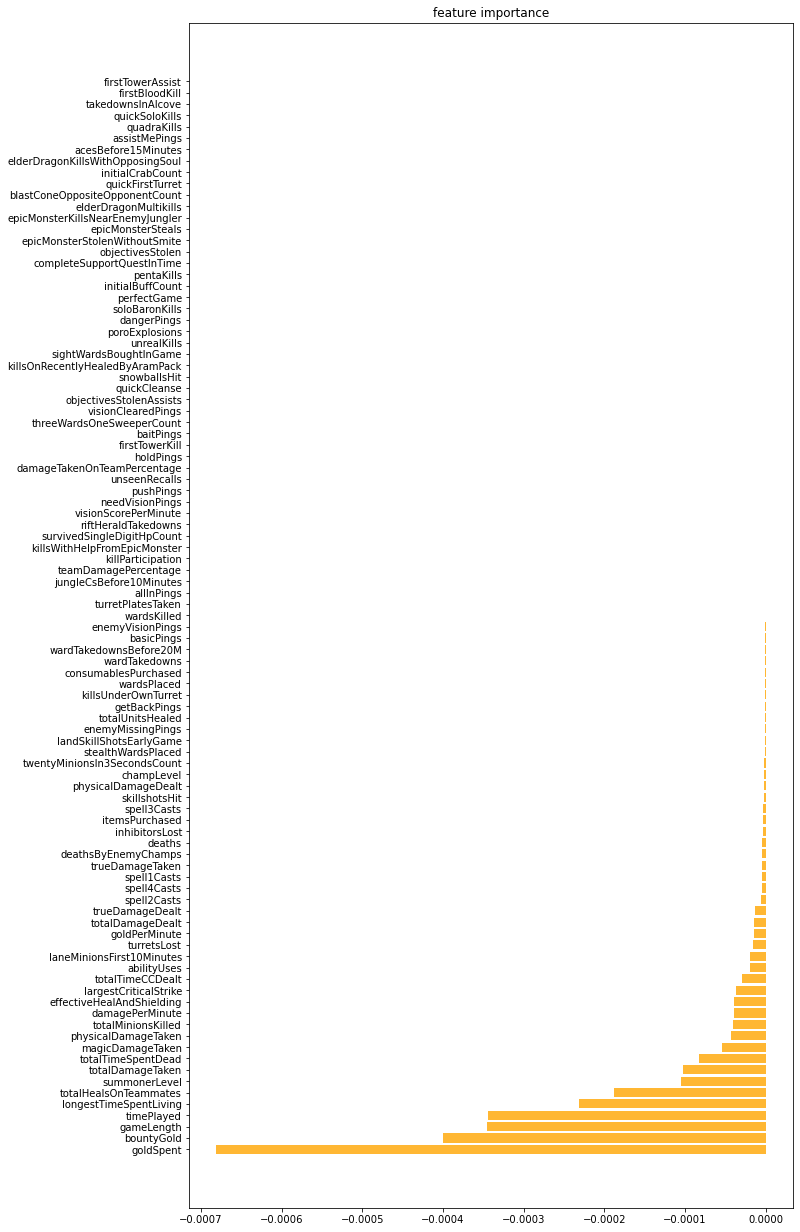

In [78]:

# define dataset
y = data_top.win
X = data_top.drop(["teamPosition", "win"], axis=1)
# define the model
model = LogisticRegression(penalty='l2')
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]

feas = pd.DataFrame()
feas['features'] = X.keys()
feas['importance'] = importance
feas = feas.sort_values(by='importance')

feas1 = feas[0:95]
feas2 = feas[95:191]

plot.rc('font', size=10);
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas1.shape[0]), feas1.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas1.shape[0]))
axes.set_yticklabels(feas1.features.values, rotation='horizontal')

plot.show()



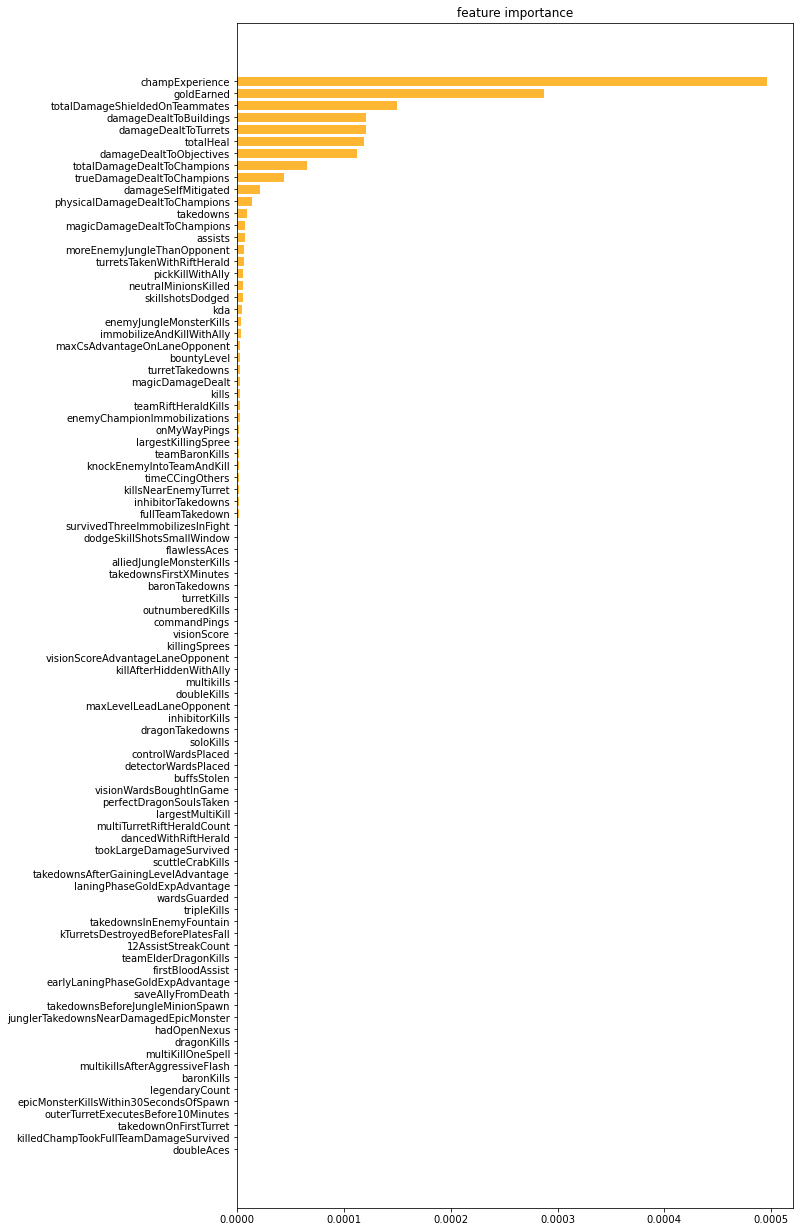

In [79]:
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas2.shape[0]), feas2.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas2.shape[0]))
axes.set_yticklabels(feas2.features.values, rotation='horizontal')
plot.show()

## Train test split and feature selection

In [80]:
y=data_top.win
X = data_top[['damagePerMinute',
            'bountyLevel', 
            'goldPerMinute',
            'champExperience',
            'visionScorePerMinute',
            'turretTakedowns',
            'kda',
            'hadOpenNexus',
            'turretsLost',
            'visionScore',
            'teamDamagePercentage',
            'totalDamageDealtToChampions',
            'killParticipation',
            'goldSpent',
            'physicalDamageDealtToChampions',
            'jungleCsBefore10Minutes',]]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,stratify=y)
'''"goldSpent", "gameLength","timePlayed","longestTimeSpentLiving","bountyGold","goldEarned","champExperience",
              "summonerLevel","damageDealtToTurrets","damageDealtToBuildings","damageDealtToObjectives","totalHealsOnTeammates"
             ,"totalDamageTaken","totalDamageShieldedOnTeammates","totalHeal","totalDamageDealtToChampions"'''

'"goldSpent", "gameLength","timePlayed","longestTimeSpentLiving","bountyGold","goldEarned","champExperience",\n              "summonerLevel","damageDealtToTurrets","damageDealtToBuildings","damageDealtToObjectives","totalHealsOnTeammates"\n             ,"totalDamageTaken","totalDamageShieldedOnTeammates","totalHeal","totalDamageDealtToChampions"'

## Baseline model - most common case

In [81]:
dummy = DummyClassifier(strategy='most_frequent').fit(Xtrain, ytrain)
ydummy = dummy.predict(Xtest)
print(confusion_matrix(ytest, ydummy))
print(classification_report(ytest, ydummy))

[[   0 1172]
 [   0 1172]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1172
           1       0.50      1.00      0.67      1172

    accuracy                           0.50      2344
   macro avg       0.25      0.50      0.33      2344
weighted avg       0.25      0.50      0.33      2344



C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## hyperparameter tuning and cross valiadation - Logistic Classifier(L2)

C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

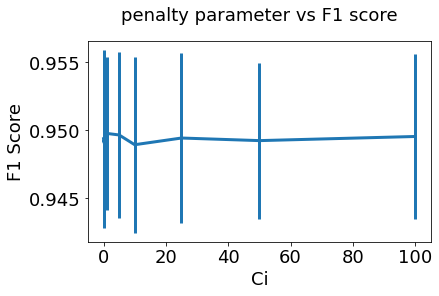

In [82]:
#cross-validation to select the weight C given to the penalty in the cost function.
mean_error=[]
std_error=[]
Ci_range = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
for Ci in Ci_range:
 model = LogisticRegression(C=Ci,penalty='l2');
 scores = cross_val_score(model,Xtrain, ytrain, cv=5, scoring='f1')
 mean_error.append(np.array(scores).mean())
 std_error.append(np.array(scores).std())
plot.rc('font', size=18); plot.rcParams['figure.constrained_layout.use'] = True
plot.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plot.title("penalty parameter vs F1 score",fontsize=18,pad=20)
plot.xlabel('Ci'); plot.ylabel('F1 Score')
plot.show()

## logistic classifier penalty l2 C=1

In [83]:
lr = LogisticRegression(penalty='l2',C=1,solver='lbfgs')
lr.fit(Xtrain,ytrain)
y_pred = lr.predict(Xtest)
print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))


[[1109   63]
 [  72 1100]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1172
           1       0.95      0.94      0.94      1172

    accuracy                           0.94      2344
   macro avg       0.94      0.94      0.94      2344
weighted avg       0.94      0.94      0.94      2344



C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## hyperparameter tuning and cross valiadation - Linear SVM

C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


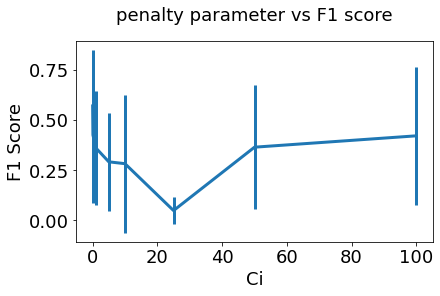

In [84]:
#cross-validation to select the weight C given to the penalty in the cost function.
mean_error=[]
std_error=[]
Ci_range = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
for Ci in Ci_range:
 model = LinearSVC(C=Ci);
 scores = cross_val_score(model,Xtrain, ytrain, cv=5, scoring='f1')
 mean_error.append(np.array(scores).mean())
 std_error.append(np.array(scores).std())
plot.rc('font', size=18); plot.rcParams['figure.constrained_layout.use'] = True
plot.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plot.title("penalty parameter vs F1 score",fontsize=18,pad=20)
plot.xlabel('Ci'); plot.ylabel('F1 Score')
plot.show()

## Linear SVM C=1

In [85]:
svm = LinearSVC(C=1)
svm.fit(Xtrain,ytrain)
y_pred1 = svm.predict(Xtest)
print(confusion_matrix(ytest, y_pred1))
print(classification_report(ytest, y_pred1))

[[1163    9]
 [1070  102]]
              precision    recall  f1-score   support

           0       0.52      0.99      0.68      1172
           1       0.92      0.09      0.16      1172

    accuracy                           0.54      2344
   macro avg       0.72      0.54      0.42      2344
weighted avg       0.72      0.54      0.42      2344



C:\Users\tomzt\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## ROC curve

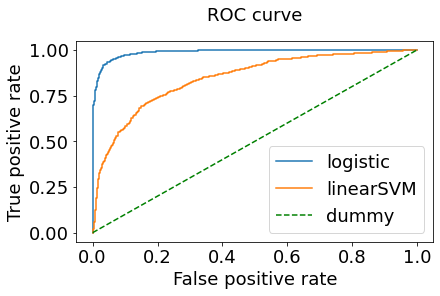

In [86]:
fpr, tpr, _ = roc_curve(ytest,lr.decision_function(Xtest))
plot.plot(fpr,tpr)
fpr1, tpr1, _ = roc_curve(ytest,svm.decision_function(Xtest))
plot.plot(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(ytest,ydummy)
plot.title("ROC curve",fontsize=18,pad=20)
plot.plot(fpr2,tpr2,color='green',linestyle='--')
plot.xlabel('False positive rate')
plot.ylabel('True positive rate')
plot.legend(["logistic","linearSVM", "dummy"]) 
plot.show()